In [ ]:
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=13Bg5OyuGDkLl0xxeC1IpKJFvYh83DY2N' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=13Bg5OyuGDkLl0xxeC1IpKJFvYh83DY2N" -O gun.zip && rm -rf /tmp/cookies.txt

--2020-07-27 15:23:29--  https://docs.google.com/uc?export=download&confirm=tk1h&id=13Bg5OyuGDkLl0xxeC1IpKJFvYh83DY2N
Resolving docs.google.com (docs.google.com)... 74.125.200.138, 74.125.200.101, 74.125.200.100, ...
Connecting to docs.google.com (docs.google.com)|74.125.200.138|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0o-8k-docs.googleusercontent.com/docs/securesc/bl7eo0ukcerrh7ita59tnr7gsv5fhqas/p24gej1219823htaugmkkonovtngbud2/1595863350000/15439536785859459434/02180564446144858727Z/13Bg5OyuGDkLl0xxeC1IpKJFvYh83DY2N?e=download [following]
--2020-07-27 15:23:29--  https://doc-0o-8k-docs.googleusercontent.com/docs/securesc/bl7eo0ukcerrh7ita59tnr7gsv5fhqas/p24gej1219823htaugmkkonovtngbud2/1595863350000/15439536785859459434/02180564446144858727Z/13Bg5OyuGDkLl0xxeC1IpKJFvYh83DY2N?e=download
Resolving doc-0o-8k-docs.googleusercontent.com (doc-0o-8k-docs.googleusercontent.com)... 74.125.200.132, 2404:6800:4003:c00::84
Connecting

In [ ]:
!unzip gun.zip

Streaming output truncated to the last 5000 lines.
  inflating: gun_data/Not_Gun/re_427images3.jpg  
  inflating: gun_data/Not_Gun/re_427images300.jpg  
  inflating: gun_data/Not_Gun/re_427images31.jpg  
  inflating: gun_data/Not_Gun/re_427images318.jpg  
  inflating: gun_data/Not_Gun/re_427images371.jpg  
  inflating: gun_data/Not_Gun/re_427images443.jpg  
  inflating: gun_data/Not_Gun/re_427images488.jpg  
  inflating: gun_data/Not_Gun/re_427images507.jpg  
  inflating: gun_data/Not_Gun/re_427images61.jpg  
  inflating: gun_data/Not_Gun/re_428images128.jpg  
  inflating: gun_data/Not_Gun/re_428images208.jpg  
  inflating: gun_data/Not_Gun/re_428images410.jpg  
  inflating: gun_data/Not_Gun/re_429images15.jpg  
  inflating: gun_data/Not_Gun/re_429images370.jpg  
  inflating: gun_data/Not_Gun/re_429images41.jpg  
  inflating: gun_data/Not_Gun/re_429images437.jpg  
  inflating: gun_data/Not_Gun/re_429images481.jpg  
  inflating: gun_data/Not_Gun/re_429images90.jpg  
  inflating: gun_dat

In [ ]:
!mkdir gun_data/train/

In [ ]:
!mv gun_data/Gun/ gun_data/train/
!mv gun_data/Not_Gun/ gun_data/train/ 

In [ ]:
#let's import all the libraries:

# all pytorch libraries
import torch
import torchvision as tv
from torchvision import datasets, transforms
from torch import optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Subset

# all necessary libraris
import numpy as np 
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import shutil
from PIL import Image
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.model_selection import train_test_split

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
# Checkwhich device you're using
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu:0")
print(device)

cuda:0


In [ ]:
broken_files = []
for i in os.listdir('/content/gun_data/train/Not_Gun'):
  try:
    filename = '/content/gun_data/train/Not_Gun/'+i
    im = Image.open(filename)
    im.verify() #I perform also verify, don't know if he sees other types o defects
    im.close() #reload is necessary in my case
    im = Image.open(filename) 
    im.transpose(Image.FLIP_LEFT_RIGHT)
    im.close()
  except Exception as e: 
    print(e,i)
    broken_files.append(filename)

cannot identify image file '/content/gun_data/train/Not_Gun/re_831images232.jpg' re_831images232.jpg
broken data stream when reading image file re_988images267.jpg
broken data stream when reading image file re_376images478.jpg
broken data stream when reading image file re_785image20.jpeg
broken data stream when reading image file re_356images127.jpg
cannot identify image file '/content/gun_data/train/Not_Gun/re_286images34.jpg' re_286images34.jpg
broken data stream when reading image file re_71images152.jpg
cannot identify image file '/content/gun_data/train/Not_Gun/re_685images28.jpg' re_685images28.jpg
broken data stream when reading image file re_134images288.jpg
broken data stream when reading image file re_137images195.jpg
broken data stream when reading image file re_75images498.jpg
cannot identify image file '/content/gun_data/train/Not_Gun/re_774images334.jpg' re_774images334.jpg
image file is truncated (18 bytes not processed) re_909images69.jpg
broken data stream when reading

In [ ]:
for i in broken_files:
  os.remove(i)

In [ ]:
data_dir = '/content/gun_data/train'

augmentations = [transforms.Resize((128,128)),
                                     transforms.ToTensor(),
                                    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])]
dataset = datasets.ImageFolder(data_dir, transform=transforms.Compose(augmentations))
print(len(dataset))


def train_val_dataset(dataset, val_split=0.20):
    train_idx, val_idx = train_test_split(list(range(len(dataset))), test_size=val_split)
    my_dataset = {}
    my_dataset['train'] = Subset(dataset, train_idx)
    my_dataset['val'] = Subset(dataset, val_idx)
    return my_dataset

my_dataset = train_val_dataset(dataset)
print(len(my_dataset['train']))
print(len(my_dataset['val']))
# The original dataset is available in the Subset class
print(my_dataset['train'].dataset)

12881
10304
2577
Dataset ImageFolder
    Number of datapoints: 12881
    Root location: /content/gun_data/train
    StandardTransform
Transform: Compose(
               Resize(size=(128, 128), interpolation=PIL.Image.BILINEAR)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )


In [ ]:
BATCH_SIZE = 64
dataloaders = {x: torch.utils.data.DataLoader(my_dataset[x], batch_size=BATCH_SIZE, shuffle=True, num_workers=1) for x in ['train', 'val']}

In [ ]:
classes = list(my_dataset['train'].dataset.class_to_idx.keys())
dataiter = iter(dataloaders['train'])

dataset_sizes = {x: len(my_dataset[x]) for x in ['train', 'val']}

images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

torch.Size([64, 3, 128, 128])
torch.Size([64])


In [ ]:
classes,dataset_sizes

(['Gun', 'Not_Gun'], {'train': 10304, 'val': 2577})

In [ ]:
dataloaders

{'train': <torch.utils.data.dataloader.DataLoader at 0x7f214cfc7748>,
 'val': <torch.utils.data.dataloader.DataLoader at 0x7f214cfc7978>}

In [ ]:
#images has 32 images from our train dataloader
images[31] , labels[31]

(tensor([[[-0.0801, -0.0629, -0.0458,  ...,  0.1768,  0.1597,  0.1426],
          [-0.0458, -0.0458, -0.0287,  ...,  0.2111,  0.1768,  0.1597],
          [-0.0287, -0.0116, -0.0116,  ...,  0.2282,  0.1939,  0.1768],
          ...,
          [-0.0801,  0.2624,  0.3481,  ...,  0.6049,  0.5878,  0.5707],
          [-0.2513,  0.2453,  0.3309,  ...,  0.5878,  0.5707,  0.5536],
          [-0.3712,  0.2111,  0.3138,  ...,  0.5707,  0.5536,  0.5193]],
 
         [[ 0.0651,  0.0826,  0.1001,  ...,  0.3452,  0.3277,  0.3102],
          [ 0.1001,  0.1001,  0.1176,  ...,  0.3803,  0.3452,  0.3277],
          [ 0.1176,  0.1352,  0.1352,  ...,  0.3978,  0.3627,  0.3452],
          ...,
          [ 0.0126,  0.3803,  0.4678,  ...,  0.7829,  0.7654,  0.7479],
          [-0.1625,  0.3627,  0.4503,  ...,  0.7654,  0.7479,  0.7304],
          [-0.2850,  0.3277,  0.4328,  ...,  0.7479,  0.7304,  0.6954]],
 
         [[ 0.3219,  0.3393,  0.3568,  ...,  0.5485,  0.5311,  0.5136],
          [ 0.3568,  0.3568,

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


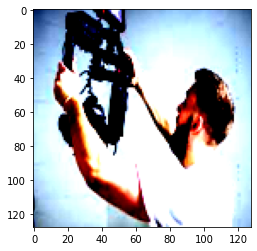

In [ ]:
tnsn_np = images[31].numpy()
plt.imshow(np.transpose(tnsn_np,(1,2,0)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

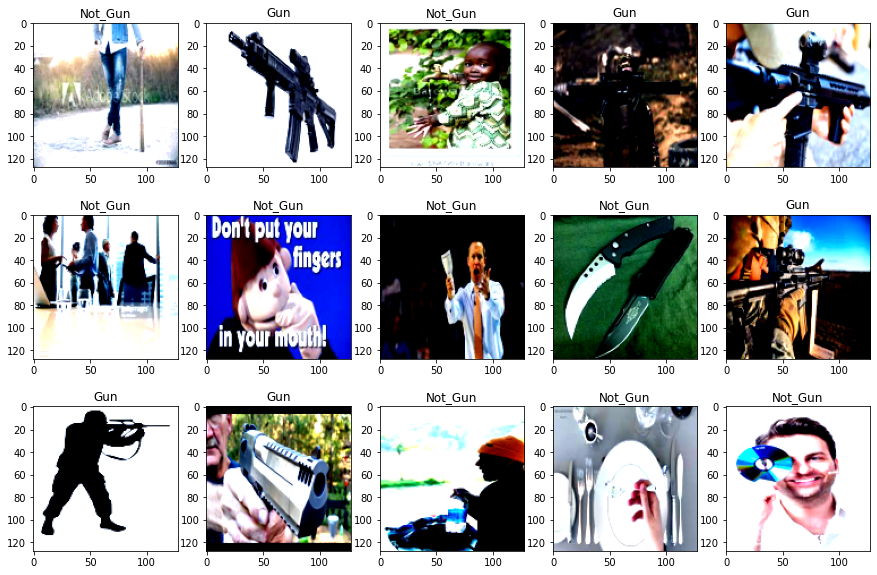

In [ ]:
def img_display(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    npimg = np.transpose(npimg, (1, 2, 0))
    return npimg

classes = {0: 'Gun', 1: 'Not_Gun'}
# Viewing data examples used for training
fig, axis = plt.subplots(3, 5, figsize=(15, 10))

for i, ax in enumerate(axis.flat):
    with torch.no_grad():
        image, label = images[i], labels[i]
        ax.imshow(img_display(image)) 
        ax.set(title ="{}".format(classes[label.item()]))

In [ ]:
images.shape

torch.Size([64, 3, 128, 128])

In [ ]:
# now we have data in dataloader with batch 32
# Let's build our neural network

class GunClassifier(nn.Module):
  def __init__(self,input_dim):
    super(GunClassifier,self).__init__()

    self.input_layer = nn.Linear(input_dim,256)
    
    self.hidden_1 = nn.Linear(256,512)
    self.dropout = nn.Dropout(0.3,True)

    self.hidden_2 = nn.Linear(512,512)
    self.dropout2 = nn.Dropout(0.5,True)

    self.hidden_3 = nn.Linear(512,256)
    self.dropout3 = nn.Dropout(0.3,True)

    self.hidden_4 = nn.Linear(256,128)
    self.output = nn.Linear(128,2)

  def forward(self,x):
    x = F.relu(self.input_layer(x))
    #print("shape is",x.shape)

    x = F.relu(self.hidden_1(x))
    #print("shape is",x.shape)

    x = F.relu(self.hidden_2(x))
    #print("shape is",x.shape)

    x = F.relu(self.hidden_3(x))
    #print("shape is",x.shape)

    x = F.relu(self.hidden_4(x))
    #print("shape is",x.shape)

    output = F.log_softmax(self.output(x),dim=1) 
    return output

input_dim = 3*128*128
gun_clf = GunClassifier(input_dim)
gun_clf

GunClassifier(
  (input_layer): Linear(in_features=49152, out_features=256, bias=True)
  (hidden_1): Linear(in_features=256, out_features=512, bias=True)
  (dropout): Dropout(p=0.3, inplace=True)
  (hidden_2): Linear(in_features=512, out_features=512, bias=True)
  (dropout2): Dropout(p=0.5, inplace=True)
  (hidden_3): Linear(in_features=512, out_features=256, bias=True)
  (dropout3): Dropout(p=0.3, inplace=True)
  (hidden_4): Linear(in_features=256, out_features=128, bias=True)
  (output): Linear(in_features=128, out_features=2, bias=True)
)

In [ ]:
outputs = gun_clf(images.reshape(-1, 3*128*128))
outputs

tensor([[-0.7656, -0.6256],
        [-0.7643, -0.6267],
        [-0.7650, -0.6261],
        [-0.7696, -0.6221],
        [-0.7703, -0.6216],
        [-0.7672, -0.6242],
        [-0.7761, -0.6165],
        [-0.7713, -0.6206],
        [-0.7656, -0.6256],
        [-0.7758, -0.6168],
        [-0.7768, -0.6159],
        [-0.7696, -0.6222],
        [-0.7623, -0.6285],
        [-0.7678, -0.6237],
        [-0.7640, -0.6269],
        [-0.7666, -0.6247],
        [-0.7695, -0.6222],
        [-0.7664, -0.6249],
        [-0.7684, -0.6231],
        [-0.7674, -0.6240],
        [-0.7630, -0.6279],
        [-0.7660, -0.6252],
        [-0.7694, -0.6223],
        [-0.7752, -0.6173],
        [-0.7641, -0.6269],
        [-0.7689, -0.6227],
        [-0.7600, -0.6305],
        [-0.7720, -0.6201],
        [-0.7775, -0.6154],
        [-0.7737, -0.6186],
        [-0.7692, -0.6225],
        [-0.7675, -0.6239],
        [-0.7692, -0.6224],
        [-0.7655, -0.6257],
        [-0.7715, -0.6205],
        [-0.7641, -0

In [ ]:
_,preds = torch.max(outputs, dim=1)
preds,labels.data

(tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]),
 tensor([1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0,
         0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1,
         1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1]))

In [ ]:
torch.sum(preds == labels.data).double()/32

tensor(1.0938, dtype=torch.float64)

In [ ]:
import time
import os
import copy

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(gun_clf.parameters(), lr=0.0001)
gun_clf = gun_clf.to(device)
criterion = criterion.to(device)

n_epochs = 20
best_acc = 0.0
best_model_wts = copy.deepcopy(gun_clf.state_dict())
since = time.time()

for epoch in range(1, n_epochs+1):
    print('Epoch {}/{}'.format(epoch, n_epochs))

    # Each epoch has a training and validation phase
    for phase in ['train', 'val']:
      if phase == 'train':
          gun_clf.train()  # Set model to training mode
      else:
          gun_clf.eval()   # Set model to evaluate mode
    
      running_loss = 0.0
      running_corrects = 0
      print('phase = ',phase)
      for batch_idx, (inputs, labels) in enumerate(dataloaders[phase]):
        inputs, labels = inputs.reshape(-1, 3*128*128).to(device), labels.to(device)

        optimizer.zero_grad()
        with torch.set_grad_enabled(phase == 'train'):
          outputs = gun_clf(inputs)
          loss = criterion(outputs, labels)
          _,preds = torch.max(outputs, dim=1)
        
          if phase == 'train':
            loss.backward()
            optimizer.step()

        running_loss += loss.item()*inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        if batch_idx%10==0:
          print("{} of {} ; loss: {}".format(batch_idx, dataset_sizes[phase] // BATCH_SIZE, loss))

      epoch_loss = running_loss / dataset_sizes[phase]
      epoch_acc = running_corrects.double() / dataset_sizes[phase]

      print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

      # deep copy the model
      if phase == 'val' and epoch_acc > best_acc:
          best_acc = epoch_acc
          best_model_wts = copy.deepcopy(gun_clf.state_dict())
          torch.save(gun_clf.state_dict(), 'best_epoch'+str(epoch)+'.pth')

time_elapsed = time.time() - since
print('Training complete in {:.0f}m {:.0f}s'.format(
    time_elapsed // 60, time_elapsed % 60))
print('Best val Acc: {:4f}'.format(best_acc))
 

Epoch 1/20
phase =  train
0 of 161 ; loss: 0.6939486861228943
10 of 161 ; loss: 0.6296027302742004


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


20 of 161 ; loss: 0.6381621360778809
30 of 161 ; loss: 0.5560257434844971
40 of 161 ; loss: 0.5631422996520996
50 of 161 ; loss: 0.5713959336280823
60 of 161 ; loss: 0.6462948322296143
70 of 161 ; loss: 0.5419055223464966
80 of 161 ; loss: 0.5884950757026672
90 of 161 ; loss: 0.5336968302726746
100 of 161 ; loss: 0.5480700135231018
110 of 161 ; loss: 0.567398190498352
120 of 161 ; loss: 0.5513642430305481
130 of 161 ; loss: 0.5136942863464355
140 of 161 ; loss: 0.5503107309341431
150 of 161 ; loss: 0.5170091390609741
160 of 161 ; loss: 0.6728392243385315
train Loss: 0.5692 Acc: 0.6974
phase =  val
0 of 40 ; loss: 0.6794101595878601
10 of 40 ; loss: 0.5343450307846069


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


20 of 40 ; loss: 0.5429409146308899
30 of 40 ; loss: 0.4783771336078644
40 of 40 ; loss: 0.6569319367408752
val Loss: 0.5460 Acc: 0.7117
Epoch 2/20
phase =  train
0 of 161 ; loss: 0.445125013589859
10 of 161 ; loss: 0.4923674464225769
20 of 161 ; loss: 0.5958507657051086
30 of 161 ; loss: 0.5188086032867432


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


40 of 161 ; loss: 0.4037427306175232
50 of 161 ; loss: 0.4097311794757843
60 of 161 ; loss: 0.3846772313117981
70 of 161 ; loss: 0.4295769929885864
80 of 161 ; loss: 0.5531920790672302
90 of 161 ; loss: 0.4853839576244354
100 of 161 ; loss: 0.5952206254005432
110 of 161 ; loss: 0.5496945977210999
120 of 161 ; loss: 0.39822152256965637
130 of 161 ; loss: 0.49396246671676636
140 of 161 ; loss: 0.5159735679626465
150 of 161 ; loss: 0.5601752996444702
160 of 161 ; loss: 0.49864375591278076
train Loss: 0.5001 Acc: 0.7516
phase =  val
0 of 40 ; loss: 0.5106016993522644
10 of 40 ; loss: 0.45490333437919617


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


20 of 40 ; loss: 0.4369264543056488
30 of 40 ; loss: 0.5231652855873108
40 of 40 ; loss: 0.413918137550354
val Loss: 0.5300 Acc: 0.7334
Epoch 3/20
phase =  train
0 of 161 ; loss: 0.4239397943019867
10 of 161 ; loss: 0.47826552391052246


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


20 of 161 ; loss: 0.5652947425842285
30 of 161 ; loss: 0.5918602347373962
40 of 161 ; loss: 0.42694059014320374
50 of 161 ; loss: 0.271065890789032
60 of 161 ; loss: 0.492942750453949
70 of 161 ; loss: 0.41001656651496887
80 of 161 ; loss: 0.5232056379318237
90 of 161 ; loss: 0.38466495275497437
100 of 161 ; loss: 0.42997974157333374
110 of 161 ; loss: 0.4066036641597748
120 of 161 ; loss: 0.47776365280151367
130 of 161 ; loss: 0.4014412760734558
140 of 161 ; loss: 0.3801628649234772
150 of 161 ; loss: 0.45342519879341125
160 of 161 ; loss: 0.5425799489021301
train Loss: 0.4580 Acc: 0.7733
phase =  val
0 of 40 ; loss: 0.4499300718307495


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


10 of 40 ; loss: 0.5535523295402527
20 of 40 ; loss: 0.6567738056182861
30 of 40 ; loss: 0.5489048361778259
40 of 40 ; loss: 0.8406809568405151
val Loss: 0.5525 Acc: 0.7194
Epoch 4/20
phase =  train
0 of 161 ; loss: 0.49614962935447693
10 of 161 ; loss: 0.500717043876648


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


20 of 161 ; loss: 0.39684364199638367
30 of 161 ; loss: 0.485598087310791
40 of 161 ; loss: 0.4433775246143341
50 of 161 ; loss: 0.3339371085166931
60 of 161 ; loss: 0.42000266909599304
70 of 161 ; loss: 0.3451322019100189
80 of 161 ; loss: 0.5513224601745605
90 of 161 ; loss: 0.4023844003677368
100 of 161 ; loss: 0.34291812777519226
110 of 161 ; loss: 0.3479527235031128
120 of 161 ; loss: 0.2759593427181244
130 of 161 ; loss: 0.47319748997688293
140 of 161 ; loss: 0.37416279315948486
150 of 161 ; loss: 0.3102511465549469
160 of 161 ; loss: 0.37242528796195984
train Loss: 0.4079 Acc: 0.8114
phase =  val


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


0 of 40 ; loss: 0.5082040429115295
10 of 40 ; loss: 0.5356640219688416
20 of 40 ; loss: 0.45394912362098694
30 of 40 ; loss: 0.45676538348197937
40 of 40 ; loss: 0.47253748774528503
val Loss: 0.4985 Acc: 0.7551
Epoch 5/20
phase =  train
0 of 161 ; loss: 0.3244805932044983
10 of 161 ; loss: 0.43036842346191406
20 of 161 ; loss: 0.28067028522491455
30 of 161 ; loss: 0.3111286759376526


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


40 of 161 ; loss: 0.3615979552268982
50 of 161 ; loss: 0.38143280148506165
60 of 161 ; loss: 0.4486992657184601
70 of 161 ; loss: 0.3627721071243286
80 of 161 ; loss: 0.31274494528770447
90 of 161 ; loss: 0.27654868364334106
100 of 161 ; loss: 0.322915643453598
110 of 161 ; loss: 0.2875160574913025
120 of 161 ; loss: 0.3416162431240082
130 of 161 ; loss: 0.4389664828777313
140 of 161 ; loss: 0.5382119417190552
150 of 161 ; loss: 0.2573712170124054
160 of 161 ; loss: 0.33844393491744995
train Loss: 0.3727 Acc: 0.8280
phase =  val
0 of 40 ; loss: 0.33813509345054626


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


10 of 40 ; loss: 0.7391214966773987
20 of 40 ; loss: 0.5864943265914917
30 of 40 ; loss: 0.525373101234436
40 of 40 ; loss: 0.6738147735595703
val Loss: 0.5601 Acc: 0.7346
Epoch 6/20
phase =  train
0 of 161 ; loss: 0.344494491815567
10 of 161 ; loss: 0.20950151979923248


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


20 of 161 ; loss: 0.21336285769939423
30 of 161 ; loss: 0.31353092193603516
40 of 161 ; loss: 0.318779319524765
50 of 161 ; loss: 0.2770580053329468
60 of 161 ; loss: 0.2579506039619446
70 of 161 ; loss: 0.24594223499298096
80 of 161 ; loss: 0.41335946321487427
90 of 161 ; loss: 0.4574674665927887
100 of 161 ; loss: 0.24575072526931763
110 of 161 ; loss: 0.26047125458717346
120 of 161 ; loss: 0.22605790197849274
130 of 161 ; loss: 0.2428278923034668
140 of 161 ; loss: 0.36511796712875366
150 of 161 ; loss: 0.22650590538978577
160 of 161 ; loss: 0.293876051902771
train Loss: 0.3144 Acc: 0.8621
phase =  val
0 of 40 ; loss: 0.48957762122154236


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


10 of 40 ; loss: 0.6076480746269226
20 of 40 ; loss: 0.42243778705596924
30 of 40 ; loss: 0.40199220180511475
40 of 40 ; loss: 0.35235506296157837
val Loss: 0.5514 Acc: 0.7664
Epoch 7/20
phase =  train
0 of 161 ; loss: 0.26003700494766235
10 of 161 ; loss: 0.11931297183036804


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


20 of 161 ; loss: 0.21668632328510284
30 of 161 ; loss: 0.18848197162151337
40 of 161 ; loss: 0.3904244899749756
50 of 161 ; loss: 0.31082648038864136
60 of 161 ; loss: 0.6200862526893616
70 of 161 ; loss: 0.2590867578983307
80 of 161 ; loss: 0.21101899445056915
90 of 161 ; loss: 0.1857118457555771
100 of 161 ; loss: 0.16523440182209015
110 of 161 ; loss: 0.2582235634326935
120 of 161 ; loss: 0.22114670276641846
130 of 161 ; loss: 0.18755210936069489
140 of 161 ; loss: 0.29908043146133423
150 of 161 ; loss: 0.2594080865383148
160 of 161 ; loss: 0.46161937713623047
train Loss: 0.2615 Acc: 0.8916
phase =  val
0 of 40 ; loss: 0.5716260671615601


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


10 of 40 ; loss: 0.6737416386604309
20 of 40 ; loss: 0.6789761185646057
30 of 40 ; loss: 0.7206501960754395
40 of 40 ; loss: 0.33905139565467834
val Loss: 0.6419 Acc: 0.7664
Epoch 8/20
phase =  train
0 of 161 ; loss: 0.25379762053489685
10 of 161 ; loss: 0.1865183711051941
20 of 161 ; loss: 0.16105060279369354
30 of 161 ; loss: 0.1597498208284378


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


40 of 161 ; loss: 0.17764241993427277
50 of 161 ; loss: 0.20309226214885712
60 of 161 ; loss: 0.14592500030994415
70 of 161 ; loss: 0.15411169826984406
80 of 161 ; loss: 0.2652173340320587
90 of 161 ; loss: 0.28126323223114014
100 of 161 ; loss: 0.24370905756950378
110 of 161 ; loss: 0.17757709324359894
120 of 161 ; loss: 0.11343672126531601
130 of 161 ; loss: 0.286102294921875
140 of 161 ; loss: 0.2046775072813034
150 of 161 ; loss: 0.1742834597826004
160 of 161 ; loss: 0.2618495523929596
train Loss: 0.2215 Acc: 0.9102
phase =  val
0 of 40 ; loss: 0.8742834329605103
10 of 40 ; loss: 0.8690773248672485
20 of 40 ; loss: 1.0132492780685425


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


30 of 40 ; loss: 0.8976122140884399
40 of 40 ; loss: 0.9445571899414062
val Loss: 0.7472 Acc: 0.7567
Epoch 9/20
phase =  train


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


0 of 161 ; loss: 0.2856733500957489
10 of 161 ; loss: 0.13437816500663757
20 of 161 ; loss: 0.28754672408103943
30 of 161 ; loss: 0.18476521968841553
40 of 161 ; loss: 0.1780281364917755
50 of 161 ; loss: 0.3802182972431183
60 of 161 ; loss: 0.12210316210985184
70 of 161 ; loss: 0.16135388612747192
80 of 161 ; loss: 0.2240353524684906
90 of 161 ; loss: 0.15006549656391144
100 of 161 ; loss: 0.11027617007493973
110 of 161 ; loss: 0.2006169557571411
120 of 161 ; loss: 0.17173928022384644
130 of 161 ; loss: 0.31701433658599854
140 of 161 ; loss: 0.1610274314880371
150 of 161 ; loss: 0.19251254200935364
160 of 161 ; loss: 0.215887650847435
train Loss: 0.1874 Acc: 0.9254
phase =  val


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


0 of 40 ; loss: 0.9368219375610352
10 of 40 ; loss: 0.7426818013191223
20 of 40 ; loss: 0.3336014747619629
30 of 40 ; loss: 0.5850812196731567
40 of 40 ; loss: 1.0827479362487793
val Loss: 0.7251 Acc: 0.7656
Epoch 10/20
phase =  train
0 of 161 ; loss: 0.16359958052635193
10 of 161 ; loss: 0.18592555820941925
20 of 161 ; loss: 0.09184955060482025
30 of 161 ; loss: 0.14757877588272095
40 of 161 ; loss: 0.15604493021965027


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


50 of 161 ; loss: 0.1700260490179062
60 of 161 ; loss: 0.3108014464378357
70 of 161 ; loss: 0.15215244889259338
80 of 161 ; loss: 0.15258854627609253
90 of 161 ; loss: 0.2047288417816162
100 of 161 ; loss: 0.15202495455741882
110 of 161 ; loss: 0.09577308595180511
120 of 161 ; loss: 0.1471039205789566
130 of 161 ; loss: 0.13584217429161072
140 of 161 ; loss: 0.24804683029651642
150 of 161 ; loss: 0.1872633993625641
160 of 161 ; loss: 0.20704089105129242
train Loss: 0.1614 Acc: 0.9363
phase =  val
0 of 40 ; loss: 0.5590872168540955


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


10 of 40 ; loss: 0.6090991497039795
20 of 40 ; loss: 1.2002876996994019
30 of 40 ; loss: 0.790641725063324
40 of 40 ; loss: 1.0420904159545898
val Loss: 0.8507 Acc: 0.7590
Epoch 11/20
phase =  train
0 of 161 ; loss: 0.16430354118347168
10 of 161 ; loss: 0.18437957763671875
20 of 161 ; loss: 0.09517928212881088


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


30 of 161 ; loss: 0.14431345462799072
40 of 161 ; loss: 0.08857415616512299
50 of 161 ; loss: 0.2502996623516083
60 of 161 ; loss: 0.13314701616764069
70 of 161 ; loss: 0.18533921241760254
80 of 161 ; loss: 0.15266813337802887
90 of 161 ; loss: 0.1425333321094513
100 of 161 ; loss: 0.1376054733991623
110 of 161 ; loss: 0.1269354671239853
120 of 161 ; loss: 0.1037156954407692
130 of 161 ; loss: 0.10437674820423126
140 of 161 ; loss: 0.17088621854782104
150 of 161 ; loss: 0.21567291021347046
160 of 161 ; loss: 0.22135676443576813
train Loss: 0.1500 Acc: 0.9412
phase =  val
0 of 40 ; loss: 0.9434438943862915


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


10 of 40 ; loss: 0.8998218178749084
20 of 40 ; loss: 0.41201260685920715
30 of 40 ; loss: 0.9009296298027039
40 of 40 ; loss: 1.1624466180801392
val Loss: 0.8060 Acc: 0.7854
Epoch 12/20
phase =  train
0 of 161 ; loss: 0.13270322978496552


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


10 of 161 ; loss: 0.13724040985107422
20 of 161 ; loss: 0.06631849706172943
30 of 161 ; loss: 0.08384601026773453
40 of 161 ; loss: 0.0942823514342308
50 of 161 ; loss: 0.09809443354606628
60 of 161 ; loss: 0.14534655213356018
70 of 161 ; loss: 0.11896670609712601
80 of 161 ; loss: 0.12141870707273483
90 of 161 ; loss: 0.06574984639883041
100 of 161 ; loss: 0.08838458359241486
110 of 161 ; loss: 0.15534983575344086
120 of 161 ; loss: 0.14021922647953033
130 of 161 ; loss: 0.10159727185964584
140 of 161 ; loss: 0.19549041986465454
150 of 161 ; loss: 0.10365511476993561
160 of 161 ; loss: 0.3014901280403137
train Loss: 0.1295 Acc: 0.9469
phase =  val


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


0 of 40 ; loss: 0.6949734091758728
10 of 40 ; loss: 0.7154105305671692
20 of 40 ; loss: 1.02043616771698
30 of 40 ; loss: 0.8553584218025208
40 of 40 ; loss: 0.7462824583053589
val Loss: 1.0092 Acc: 0.7738
Epoch 13/20
phase =  train
0 of 161 ; loss: 0.13055232167243958
10 of 161 ; loss: 0.14950314164161682
20 of 161 ; loss: 0.19544070959091187
30 of 161 ; loss: 0.2076653689146042


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


40 of 161 ; loss: 0.10823982954025269
50 of 161 ; loss: 0.17790643870830536
60 of 161 ; loss: 0.059155914932489395
70 of 161 ; loss: 0.08379732072353363
80 of 161 ; loss: 0.1230466440320015
90 of 161 ; loss: 0.06781228631734848
100 of 161 ; loss: 0.0869615226984024
110 of 161 ; loss: 0.058086689561605453
120 of 161 ; loss: 0.10755191743373871
130 of 161 ; loss: 0.15469950437545776
140 of 161 ; loss: 0.08716721087694168
150 of 161 ; loss: 0.02670350670814514
160 of 161 ; loss: 0.16746702790260315
train Loss: 0.1251 Acc: 0.9507
phase =  val
0 of 40 ; loss: 1.1838183403015137


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


10 of 40 ; loss: 0.9148552417755127
20 of 40 ; loss: 1.013047218322754
30 of 40 ; loss: 1.2538280487060547
40 of 40 ; loss: 0.5724048018455505
val Loss: 0.8958 Acc: 0.7691
Epoch 14/20
phase =  train
0 of 161 ; loss: 0.08721433579921722


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


10 of 161 ; loss: 0.07798982411623001
20 of 161 ; loss: 0.14510668814182281
30 of 161 ; loss: 0.05671744421124458
40 of 161 ; loss: 0.08106010407209396
50 of 161 ; loss: 0.1620466709136963
60 of 161 ; loss: 0.03173794224858284
70 of 161 ; loss: 0.15830601751804352
80 of 161 ; loss: 0.10915948450565338
90 of 161 ; loss: 0.09045615047216415
100 of 161 ; loss: 0.0990120992064476
110 of 161 ; loss: 0.07472321391105652
120 of 161 ; loss: 0.15773092210292816
130 of 161 ; loss: 0.10489396750926971
140 of 161 ; loss: 0.08731486648321152
150 of 161 ; loss: 0.13332624733448029
160 of 161 ; loss: 0.11158538609743118
train Loss: 0.0987 Acc: 0.9615
phase =  val
0 of 40 ; loss: 0.8013855218887329


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


10 of 40 ; loss: 0.8119805455207825
20 of 40 ; loss: 0.8844105005264282
30 of 40 ; loss: 1.8345087766647339
40 of 40 ; loss: 0.5397517085075378
val Loss: 1.0193 Acc: 0.7811
Epoch 15/20
phase =  train
0 of 161 ; loss: 0.05277428403496742
10 of 161 ; loss: 0.1748695820569992
20 of 161 ; loss: 0.16845442354679108
30 of 161 ; loss: 0.15770727396011353


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


40 of 161 ; loss: 0.1862364411354065
50 of 161 ; loss: 0.08530929684638977
60 of 161 ; loss: 0.03803795576095581
70 of 161 ; loss: 0.09064047783613205
80 of 161 ; loss: 0.07842162996530533
90 of 161 ; loss: 0.14665699005126953
100 of 161 ; loss: 0.06585406512022018
110 of 161 ; loss: 0.05445043742656708
120 of 161 ; loss: 0.03392969071865082
130 of 161 ; loss: 0.04111136496067047
140 of 161 ; loss: 0.1048700213432312
150 of 161 ; loss: 0.018026582896709442
160 of 161 ; loss: 0.05503460392355919
train Loss: 0.0902 Acc: 0.9651
phase =  val
0 of 40 ; loss: 1.5097509622573853


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


10 of 40 ; loss: 1.0160168409347534
20 of 40 ; loss: 0.789851725101471
30 of 40 ; loss: 0.5678036212921143
40 of 40 ; loss: 0.5437087416648865
val Loss: 0.9771 Acc: 0.7877
Epoch 16/20
phase =  train
0 of 161 ; loss: 0.02814595215022564
10 of 161 ; loss: 0.06076667830348015
20 of 161 ; loss: 0.048111919313669205
30 of 161 ; loss: 0.08318030089139938
40 of 161 ; loss: 0.1468740850687027


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


50 of 161 ; loss: 0.030504416674375534
60 of 161 ; loss: 0.01634622924029827
70 of 161 ; loss: 0.11046600341796875
80 of 161 ; loss: 0.023067858070135117
90 of 161 ; loss: 0.08364425599575043
100 of 161 ; loss: 0.05145478993654251
110 of 161 ; loss: 0.029759930446743965
120 of 161 ; loss: 0.06147526577115059
130 of 161 ; loss: 0.1014661192893982
140 of 161 ; loss: 0.05207936465740204
150 of 161 ; loss: 0.0802907645702362
160 of 161 ; loss: 0.021596746519207954
train Loss: 0.0823 Acc: 0.9682
phase =  val
0 of 40 ; loss: 1.1920994520187378


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


10 of 40 ; loss: 0.8731494545936584
20 of 40 ; loss: 1.054150938987732
30 of 40 ; loss: 1.0210376977920532
40 of 40 ; loss: 0.21482400596141815
val Loss: 1.1085 Acc: 0.7575
Epoch 17/20
phase =  train
0 of 161 ; loss: 0.10559730976819992


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


10 of 161 ; loss: 0.07740974426269531
20 of 161 ; loss: 0.0703076496720314
30 of 161 ; loss: 0.042467162013053894
40 of 161 ; loss: 0.004086900968104601
50 of 161 ; loss: 0.056709036231040955
60 of 161 ; loss: 0.16881796717643738
70 of 161 ; loss: 0.15978753566741943
80 of 161 ; loss: 0.01953602023422718
90 of 161 ; loss: 0.051542334258556366
100 of 161 ; loss: 0.06512818485498428
110 of 161 ; loss: 0.06937754899263382
120 of 161 ; loss: 0.13312159478664398
130 of 161 ; loss: 0.3047097623348236
140 of 161 ; loss: 0.11585555970668793
150 of 161 ; loss: 0.1966075301170349
160 of 161 ; loss: 0.24395594000816345
train Loss: 0.0822 Acc: 0.9694
phase =  val
0 of 40 ; loss: 0.6591702699661255
10 of 40 ; loss: 0.8407596945762634


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


20 of 40 ; loss: 0.7355005741119385
30 of 40 ; loss: 0.6162043809890747
40 of 40 ; loss: 0.06749968975782394
val Loss: 1.0070 Acc: 0.7800
Epoch 18/20
phase =  train
0 of 161 ; loss: 0.11547425389289856


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


10 of 161 ; loss: 0.05214729905128479
20 of 161 ; loss: 0.03083048388361931
30 of 161 ; loss: 0.04637855663895607
40 of 161 ; loss: 0.08072365075349808
50 of 161 ; loss: 0.11652233451604843
60 of 161 ; loss: 0.06738486886024475
70 of 161 ; loss: 0.1258689910173416
80 of 161 ; loss: 0.052617523819208145
90 of 161 ; loss: 0.01392317097634077
100 of 161 ; loss: 0.11606670916080475
110 of 161 ; loss: 0.029875999316573143
120 of 161 ; loss: 0.08845516294240952
130 of 161 ; loss: 0.05287723243236542
140 of 161 ; loss: 0.06534852832555771
150 of 161 ; loss: 0.02260413207113743
160 of 161 ; loss: 0.06820527464151382
train Loss: 0.0745 Acc: 0.9716
phase =  val
0 of 40 ; loss: 0.9145749807357788
10 of 40 ; loss: 1.2447844743728638
20 of 40 ; loss: 1.1409540176391602


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


30 of 40 ; loss: 0.6708540320396423
40 of 40 ; loss: 2.7309553623199463
val Loss: 1.0440 Acc: 0.7870
Epoch 19/20
phase =  train
0 of 161 ; loss: 0.0309176966547966
10 of 161 ; loss: 0.2159452587366104


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


20 of 161 ; loss: 0.18439394235610962
30 of 161 ; loss: 0.044494811445474625
40 of 161 ; loss: 0.028637241572141647
50 of 161 ; loss: 0.07474690675735474
60 of 161 ; loss: 0.026427308097481728
70 of 161 ; loss: 0.07460528612136841
80 of 161 ; loss: 0.11328838020563126
90 of 161 ; loss: 0.11389058828353882
100 of 161 ; loss: 0.0798751637339592
110 of 161 ; loss: 0.04307140037417412
120 of 161 ; loss: 0.10091928392648697
130 of 161 ; loss: 0.08605201542377472
140 of 161 ; loss: 0.14299634099006653
150 of 161 ; loss: 0.037881143391132355
160 of 161 ; loss: 0.03092029131948948
train Loss: 0.0736 Acc: 0.9734
phase =  val
0 of 40 ; loss: 0.9591071009635925
10 of 40 ; loss: 1.7019391059875488


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


20 of 40 ; loss: 0.7774938344955444
30 of 40 ; loss: 1.5631808042526245
40 of 40 ; loss: 0.7086494565010071
val Loss: 1.1726 Acc: 0.7842
Epoch 20/20
phase =  train
0 of 161 ; loss: 0.05662921443581581
10 of 161 ; loss: 0.08190371841192245


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


20 of 161 ; loss: 0.06935891509056091
30 of 161 ; loss: 0.05209069699048996
40 of 161 ; loss: 0.12469804286956787
50 of 161 ; loss: 0.07606781274080276
60 of 161 ; loss: 0.04662276804447174
70 of 161 ; loss: 0.11884000152349472
80 of 161 ; loss: 0.167654350399971
90 of 161 ; loss: 0.050784699618816376
100 of 161 ; loss: 0.08334217220544815
110 of 161 ; loss: 0.1571425497531891
120 of 161 ; loss: 0.13085778057575226
130 of 161 ; loss: 0.050854265689849854
140 of 161 ; loss: 0.011173649691045284
150 of 161 ; loss: 0.13254983723163605
160 of 161 ; loss: 0.12312819063663483
train Loss: 0.0619 Acc: 0.9775
phase =  val
0 of 40 ; loss: 1.9546631574630737
10 of 40 ; loss: 1.7021840810775757


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


20 of 40 ; loss: 1.1490440368652344
30 of 40 ; loss: 0.7540274262428284
40 of 40 ; loss: 1.2655720710754395
val Loss: 1.2649 Acc: 0.7967
Training complete in 15m 3s
Best val Acc: 0.796663


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

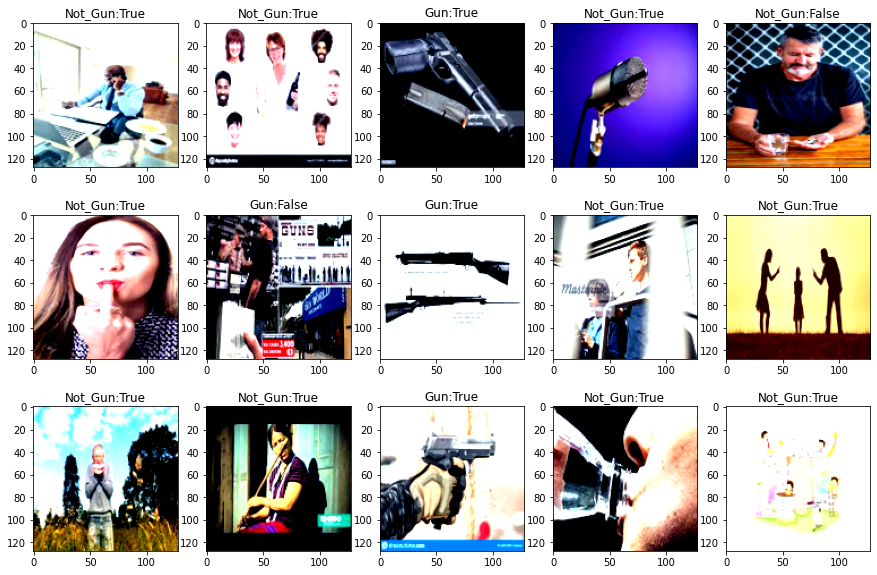

In [ ]:
dataiter = iter(dataloaders['val'])
images, labels = dataiter.next()
classes = {0: 'Gun', 1: 'Not_Gun'}
# Viewing data examples used for training
fig, axis = plt.subplots(3, 5, figsize=(15, 10))
with torch.no_grad():
    gun_clf.eval()
    for ax, image, label in zip(axis.flat,images, labels):
        ax.imshow(img_display(image)) # add image
        image_tensor = image.reshape(-1, 3*128*128).to(device)
        output_ = gun_clf(image_tensor)
        output_ = output_.argmax()
        k = output_.item()==label.item()
        ax.set_title(str(classes[label.item()])+":" +str(k)) # add label

